In [ ]:
!pip install d2l

In [1]:
!pip install "syne-tune[gpsearchers]==0.3.2"

In [2]:
import logging  # Loglama işlemleri için logging modülünü içe aktarır
from d2l import torch as d2l  # D2L kütüphanesini PyTorch için içe aktarır

logging.basicConfig(level=logging.INFO)  # Bilgi seviyesinde loglama başlatılır
import matplotlib.pyplot as plt  # Grafikler için matplotlib modülü içe aktarılır
from syne_tune import StoppingCriterion, Tuner  # SyneTune'dan durdurma kriteri ve tuner sınıfları içe aktarılır
from syne_tune.backend.python_backend import PythonBackend  # Python arka planda çalışacak backend içe aktarılır
from syne_tune.config_space import loguniform, randint  # Konfigürasyon alanı için rastgele seçim fonksiyonları
from syne_tune.experiments import load_experiment  # Deney yükleme fonksiyonu
from syne_tune.optimizer.baselines import ASHA  # ASHA optimizasyon algoritması içe aktarılır


AWS dependencies are not imported since dependencies are missing. You can install them with
   pip install 'syne-tune[aws]'
or (for everything)
   pip install 'syne-tune[extra]'
AWS dependencies are not imported since dependencies are missing. You can install them with
   pip install 'syne-tune[aws]'
or (for everything)
   pip install 'syne-tune[extra]'


In [3]:
def hpo_objective_lenet_synetune(learning_rate, batch_size, max_epochs):
    from syne_tune import Reporter  # SyneTune'dan Reporter sınıfı içe aktarılır (sonuç raporlamak için)
    from d2l import torch as d2l  # D2L kütüphanesi PyTorch için içe aktarılır

    model = d2l.LeNet(lr=learning_rate, num_classes=10)  # LeNet modelini oluşturur, öğrenme oranı ve sınıf sayısı belirlenir
    trainer = d2l.HPOTrainer(max_epochs=1, num_gpus=1)  # Model eğitimi için HPOTrainer sınıfı, bir GPU ile başlatılır
    data = d2l.FashionMNIST(batch_size=batch_size)  # FashionMNIST veri seti, belirli batch boyutunda yüklenir
    model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)  # Modelin parametreleri CNN ile başlatılır

    report = Reporter()  # Sonuçları raporlamak için Reporter nesnesi oluşturulur
    for epoch in range(1, max_epochs + 1):  # Belirtilen maksimum epoch sayısına kadar eğitim yapılır
        if epoch == 1:
            # İlk epoch'ta Trainer'ı başlat ve fit işlemini gerçekleştir
            trainer.fit(model=model, data=data)
        else:
            trainer.fit_epoch()  # Sonraki epoch'larda sadece fit_epoch çağrılır

        validation_error = trainer.validation_error().cpu().detach().numpy()  # Geçerlilik hatası hesaplanır
        report(epoch=epoch, validation_error=float(validation_error))  # Epoch ve doğrulama hatası raporlanır


In [4]:
min_number_of_epochs = 2  # Eğitimde minimum epoch sayısı belirlenir
max_number_of_epochs = 10  # Eğitimde maksimum epoch sayısı belirlenir
eta = 2  # Eğitimde öğrenme oranı (learning rate) değişim oranı

config_space = {
    "learning_rate": loguniform(1e-2, 1),  # Öğrenme oranı, 1e-2 ile 1 arasında logaritmik dağılımla seçilir
    "batch_size": randint(32, 256),  # Batch boyutu, 32 ile 256 arasında rastgele bir değer seçilir
    "max_epochs": max_number_of_epochs,  # Maksimum epoch sayısı olarak yukarıda tanımlanan değeri alır
}

initial_config = {
    "learning_rate": 0.1,  # Başlangıçta öğrenme oranı 0.1 olarak belirlenir
    "batch_size": 128,  # Başlangıçta batch boyutu 128 olarak belirlenir
}


In [10]:
n_workers = 2  # Needs to be <= the number of available GPUs
max_wallclock_time = 12 * 60  # 12 minutes

In [11]:
mode = "min"  # Performans ölçütü olan metrik, düşük olmasını hedefler (örneğin hata oranı)
metric = "validation_error"  # Değerlendirilen metrik, doğrulama hatası olarak belirlenir
resource_attr = "epoch"  # Kaynak olarak epoch kullanılır (yani, her epoch sonrası değerlendirme yapılır)

# ASHA (Asynchronous Successive Halving Algorithm) sınıfı ile hiperparametre optimizasyonu başlatılır
scheduler = ASHA(
    config_space,  # Hiperparametre arama alanı
    metric=metric,  # İzlenecek metrik
    mode=mode,  # Düşük metrik hedefi
    points_to_evaluate=[initial_config],  # Başlangıç için değerlendirilecek konfigürasyon
    max_resource_attr="max_epochs",  # Maksimum kaynak, burada max_epochs kullanılır
    resource_attr=resource_attr,  # Kaynak (epoch) kullanılarak değerlendirilecek
    grace_period=min_number_of_epochs,  # İlk dönem için tolerans süresi (başlangıçta min_number_of_epochs)
    reduction_factor=eta,  # Hiperparametreler arasında performansın nasıl azaltılacağını belirler (eta)
)


In [12]:
trial_backend = PythonBackend(
    tune_function=hpo_objective_lenet_synetune,
    config_space=config_space,
)

stop_criterion = StoppingCriterion(max_wallclock_time=max_wallclock_time)
tuner = Tuner(
    trial_backend=trial_backend,
    scheduler=scheduler,
    stop_criterion=stop_criterion,
    n_workers=n_workers,
    print_update_interval=int(max_wallclock_time * 0.6),
)
tuner.run()

--------------------
Resource summary (last result is reported):
 trial_id     status  iter  learning_rate  batch_size  max_epochs  epoch  validation_error  worker-time
        0 InProgress     9       0.100000         128          10    9.0          0.288074   666.953499
        1    Stopped     8       0.187800          99          10    8.0          0.429293   635.374459
        2 InProgress     0       0.256307          46          10      -                 -            -
2 trials running, 1 finished (0 until the end), 722.07s wallclock-time

validation_error: best 0.2880735993385315 for trial-id 0
--------------------


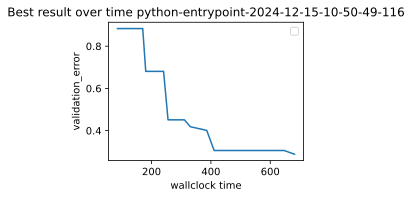

In [13]:
d2l.set_figsize()  # Grafiklerin boyutlarını ayarlamak için D2L kütüphanesindeki set_figsize fonksiyonu çağrılır

e = load_experiment(tuner.name)  # Tuned modelin geçmiş deneyini yükler. 'tuner.name' ile deneyin adı alınır.
e.plot()  # Yüklenen deneyin grafiğini çizdirir (örneğin, doğrulama hatası vs. epoch)


Text(0, 0.5, 'objective function')

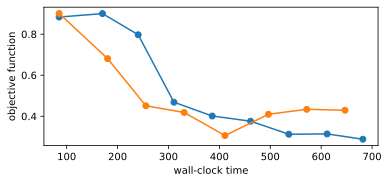

In [14]:
d2l.set_figsize([6, 2.5])  # Grafik boyutları [6, 2.5] olarak ayarlanır.

results = e.results  # Deney sonuçları 'results' değişkenine atanır.

# Her bir deneme için (trial_id) sonuçlar döngüye alınır
for trial_id in results.trial_id.unique():
    df = results[results["trial_id"] == trial_id]  # Bu trial_id için veriler filtrelenir.
    # Sonuçların grafikleştirilmesi
    d2l.plt.plot(
        df["st_tuner_time"],  # X eksenine tuner zamanları (saat cinsinden) konur
        df["validation_error"],  # Y eksenine doğrulama hatası yerleştirilir
        marker="o"  # Noktalarla işaretlenmiş grafik çizilir
    )

# Grafik etiketlerinin eklenmesi
d2l.plt.xlabel("wall-clock time")  # X ekseni için etiket
d2l.plt.ylabel("objective function")  # Y ekseni için etiket
